In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.torch_core import *
from fastai.callback import *
from fastai.basic_train import *

import pandas as pd
import numpy as np
import os
import torchvision
from fastai.callbacks import *


dfFile = "/home/santhosr/Documents/Birad/FastAI/RaceClassification/DataFile5.csv"

modelName = 'model_resnet50_id6_acc823_loss449'


#Feature Directories
trainFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/Features/model6/train'

validFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/Features/model6/valid'

def getRaceLabel(x,binary=False):
    ID = x.split("/")[-1].split("_")[0]
    label = truth[truth.DummyID == int(ID)]['Medview_Race'].values[0]

    if label == 'African American':
        return 0
    elif label == "White":
        return 1
    else:
        return 2
    

truthFile = '/home/santhosr/Documents/Birad/birad_targetFile.csv'
truth = pd.read_csv(truthFile)

df = pd.read_csv(dfFile)

final = pd.read_csv("/home/santhosr/Documents/Birad/FastAI/RaceClassification/Final.csv")
keepList = ['ImageName','VolumetricBreastDensity','DenseAreaPercent']
final = final[keepList]

df['ImageName'] = df.files.apply(lambda x : x.split(".")[0].split("/")[1])

#merging with final to retrieve the density metrics
df = pd.merge(df, final, on='ImageName',how='left')

#removing instances which dont have breast density values
df = df.loc[~pd.isna(df.VolumetricBreastDensity)]
    

/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (65,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
data = ImageItemList.from_df(df=df,path='/home/santhosr/Documents/Birad/ProcessedData/FullRes/', cols='files').split_from_df(col='train').label_from_func(getRaceLabel).transform(get_transforms(),size=256).databunch(bs=100).normalize()
print("Dataset created")

learn = create_cnn(data, models.resnet50, metrics=accuracy,pretrained=True)

learn.load('/home/santhosr/Documents/Birad/ProcessedData/models/'+modelName)



Dataset created


Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12326 items)
[Category 1, Category 0, Category 1, Category 0, Category 0]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes
x: ImageItemList (12326 items)
[Image (3, 4096, 3328), Image (3, 4096, 3328), Image (3, 3328, 2560), Image (3, 3328, 2560), Image (3, 4096, 3328)]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes;

Valid: LabelList
y: CategoryList (3091 items)
[Category 1, Category 0, Category 1, Category 1, Category 1]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes
x: ImageItemList (3091 items)
[Image (3, 4096, 3328), Image (3, 4096, 3328), Image (3, 3328, 2560), Image (3, 4096, 3328), Image (3, 4096, 3328)]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [18]:
learn = create_cnn(data, models.resnet50, metrics=accuracy,pretrained=True)

In [49]:
learn = create_cnn(data, models.resnet34, metrics=accuracy,pretrained=True)

learn.load('/home/santhosr/Documents/Birad/ProcessedData/models/'+modelName)

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12349 items)
[Category 1, Category 1, Category 0, Category 0, Category 1]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes
x: ImageItemList (12349 items)
[Image (3, 4096, 3328), Image (3, 3328, 2560), Image (3, 4096, 3328), Image (3, 3328, 2560), Image (3, 3328, 2560)]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes;

Valid: LabelList
y: CategoryList (3098 items)
[Category 0, Category 1, Category 1, Category 1, Category 1]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes
x: ImageItemList (3098 items)
[Image (3, 4096, 3328), Image (3, 4096, 3328), Image (3, 4096, 3328), Image (3, 3328, 2560), Image (3, 4096, 3328)]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

#### Utils

In [3]:
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name,folder='/home/santhosr/Documents/Codes/FastAI/Visualization'):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
#     if not os.path.exists('../results'):
#         os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join(folder, file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def save_image(im, path):
    """
        Saves a numpy matrix of shape D(1 or 3) x W x H as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, np.ndarray):
        if len(im.shape) == 2:
            im = np.expand_dims(im, axis=0)
        if im.shape[0] == 1:
            # Converting an image with depth = 1 to depth = 3, repeating the same values
            # For some reason PIL complains when I want to save channel image as jpg without
            # additional format in the .save()
            im = np.repeat(im, 3, axis=0)
            # Convert to values to range 1-255 and W,H, D
        if im.shape[0] == 3:
            im = im.transpose(1, 2, 0) * 255
        im = Image.fromarray(im.astype(np.uint8))
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((512, 512))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('../input_images/snake.jpg', 56),
                    ('../input_images/cat_dog.png', 243),
                    ('../input_images/spider.png', 72))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

In [55]:
list(learn.model._modules.items())[0][1][0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

### Guided BackProp

In [4]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
            print('grad added')
        # Register hook to the first layer
#         first_layer = list(self.model.features._modules.items())[0][1]
        first_layer = list(self.model._modules.items())[0][1][0]  # modifying for our case
        print(first_layer)
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)
        
        def attachHook(module):
            """
            Recursively attachs hooks to all ReLU layers across model
            """
    
            for i in module.children():
            
#                 print(type(i))

                if isinstance(i,ReLU):
                    i.register_backward_hook(relu_backward_hook_function)
                    i.register_forward_hook(relu_forward_hook_function)
                    print("Attached")
    
                if type(i)== torchvision.models.resnet.Bottleneck:
                    print("Inside")
                    attachHook(i)
                
                if type(i)==torch.nn.modules.container.Sequential:
                    print("Inside")
                    attachHook(i)
                    
                    
            
        attachHook(self.model)
        

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        print(model_output)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        ohe = one_hot_output.to(device)
        # Backward pass
        model_output.backward(gradient=ohe)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

In [5]:
from torch.nn import ReLU

In [6]:

GBP = GuidedBackprop(learn.model)

Inside
Attached
Inside
Inside
Attached
Inside
Inside
Attached
Inside
Attached
Inside
Inside
Attached
Inside
Inside
Attached
Inside
Attached
Inside
Attached
Inside
Inside
Attached
Inside
Inside
Attached
Inside
Attached
Inside
Attached
Inside
Attached
Inside
Attached
Inside
Inside
Attached
Inside
Inside
Attached
Inside
Attached
Inside
Attached
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

0
tensor([[ 1.2764, -1.0890]], device='cuda:0', grad_fn=<AddmmBackward>)
grad added


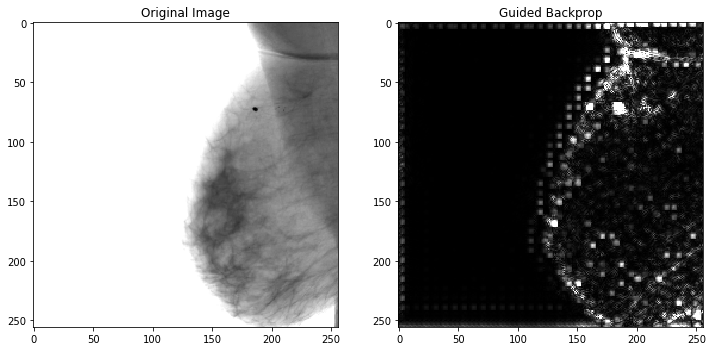

In [13]:
##### TESTING CODE
i=23
r=data.one_item(data.valid_ds.x[i])
r[0].requires_grad = True
# target = int(data.valid_dl.y[i])
target = r[1].cpu().numpy()[0]
print(target)

guided_grads = GBP.generate_gradients(r[0], target)
# Save colored gradients
save_gradient_images(guided_grads, 'snake_grad' + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)

plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
# plt.text(10,1200,"Label : {}".format(target))
plt.imshow(r[0].detach().cpu().numpy()[0].transpose((1,2,0))[:,:,0],cmap='gray')
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(grayscale_guided_grads[0],cmap='gray')
plt.title("Guided Backprop")


plt.show()

In [14]:
e=r[0].detach().cpu().numpy()[0].transpose((1,2,0))[:,:,0]

In [34]:
e.shape

(256, 256)

In [16]:
import os
os.getcwd()

'/home/santhosr/Documents/Birad/FastAI/RaceClassification/Visualization'